Real World Tutorial 1: Translating Poetry
=========================================

First example
-------------

We build workflows by calling functions. The simplest example of this
is the "diamond workflow":

In [1]:
from noodles import run_single
from noodles.tutorial import (add, sub, mul)

u = add(5, 4)
v = sub(u, 3)
w = sub(u, 2)
x = mul(v, w)

answer = run_single(x)

print("The answer is {0}.".format(answer))

The answer is 42.


That looks like any other Python code! But this example is a bit silly.
How do we leverage Noodles to earn an honest living? Here's a slightly less
silly example (but only just!). We will build a small translation engine
that translates sentences by submitting each word to an online dictionary
over a Rest API. To do this we make loops ("For thou shalt make loops of 
blue"). First we build the program as you would do in Python, then we
sprinkle some Noodles magic and make it work parallel! Furthermore, we'll
see how to:

    * make more loops
    * cache results for reuse

## Making loops

Thats all swell, but how do we make a parallel loop? Let's look at a `map` operation; in Python there are several ways to perform a function on all elements in an array. For this example, we will translate some words using the Glosbe service, which has a nice REST interface. We first build some functionality to use this interface.

In [2]:
import urllib.request
import json
import re


class Translate:
    """Translate words and sentences in the worst possible way. The Glosbe dictionary
    has a nice REST interface that we query for a phrase. We then take the first result.
    To translate a sentence, we cut it in pieces, translate it and paste it back into
    a Frankenstein monster."""
    def __init__(self, src_lang='en', tgt_lang='fy'):
        self.src = src_lang
        self.tgt = tgt_lang
        self.url = 'https://glosbe.com/gapi/translate?' \
                   'from={src}&dest={tgt}&' \
                   'phrase={{phrase}}&format=json'.format(
                        src=src_lang, tgt=tgt_lang)
    
    def query_phrase(self, phrase):
        with urllib.request.urlopen(self.url.format(phrase=phrase.lower())) as response:
            translation = json.loads(response.read().decode())
        return translation

    def word(self, phrase):
        translation = self.query_phrase(phrase)
        #translation = {'tuc': [{'phrase': {'text': phrase.lower()[::-1]}}]}
        if len(translation['tuc']) > 0 and 'phrase' in translation['tuc'][0]:
            result = translation['tuc'][0]['phrase']['text']
            if phrase[0].isupper():
                return result.title()
            else:
                return result            
        else:
            return "<" + phrase + ">"
    
    def sentence(self, phrase):
        words = re.sub("[^\w]", " ", phrase).split()
        space = re.sub("[\w]+", "{}", phrase)
        return space.format(*map(self.word, words))

We start with a list of strings that desparately need translation. And add a little
routine to print it in a gracious manner.

In [3]:
shakespeare = [
    "If music be the food of love, play on,",
    "Give me excess of it; that surfeiting,",
    "The appetite may sicken, and so die."]

def print_poem(intro, poem):
    print(intro)
    for line in poem:
        print("     ", line)
    print()

print_poem("Original:", shakespeare)

Original:
      If music be the food of love, play on,
      Give me excess of it; that surfeiting,
      The appetite may sicken, and so die.



Beginning Python programmers like to append things; this is not how you are
supposed to program in Python; if you do, please go and read Jeff Knupp's *Writing Idiomatic Python*.

In [4]:
shakespeare_auf_deutsch = []
for line in shakespeare:
    shakespeare_auf_deutsch.append(
        Translate('en', 'de').sentence(line))
print_poem("Auf Deutsch:", shakespeare_auf_deutsch)

Auf Deutsch:
      Wenn Musik sein der Essen von Minne, spielen an,
      Geben ich Übermaß von es; das übersättigend,
      Der Appetit dürfen erkranken, und so sterben.



Rather use a comprehension like so:

In [5]:
shakespeare_ynt_frysk = \
    (Translate('en', 'fy').sentence(line) for line in shakespeare)
print_poem("Yn it Frysk:", shakespeare_ynt_frysk)

Yn it Frysk:
      At muzyk wêze de fiedsel fan leafde, boartsje oan,
      Jaan <me> by fersin fan it; dat <surfeiting>,
      De <appetite> maaie <sicken>, en dus deagean.



Or use `map`:

In [6]:
shakespeare_pa_dansk = \
    map(Translate('en', 'da').sentence, shakespeare)
print_poem("På Dansk:", shakespeare_pa_dansk)

På Dansk:
      Hvis musik være de mad af kærlighed, spil på,
      Give mig udskejelser af det; som <surfeiting>,
      De appetit må <sicken>, og så dø.



## Noodlify!
If your connection is a bit slow, you may find that the translations take a while to process. Wouldn't it be nice to do it in parallel? How much code would we have to change to get there in Noodles? Let's take the slow part of the program and add a `@schedule` decorator, and run! Sadly, it is not that simple. We can add `@schedule` to the `word` method. This means that it will return a promise. 

* Rule: *Functions that take promises need to be scheduled functions, or refer to a scheduled function at some level.* 

We could write

    return schedule(space.format)(*(self.word(w) for w in words))
    
in the last line of the `sentence` method, but the string format method doesn't support wrapping. We rely on getting the signature of a function by calling `inspect.signature`. In some cases of build-in function this raises an exception. We may find a work around for these cases in future versions of Noodles. For the moment we'll have to define a little wrapper function.

In [7]:
from noodles import schedule


@schedule
def format_string(s, *args, **kwargs):
    return s.format(*args, **kwargs)


import urllib.request
import json
import re


class Translate:
    """Translate words and sentences in the worst possible way. The Glosbe dictionary
    has a nice REST interface that we query for a phrase. We then take the first result.
    To translate a sentence, we cut it in pieces, translate it and paste it back into
    a Frankenstein monster."""
    def __init__(self, src_lang='en', tgt_lang='fy'):
        self.src = src_lang
        self.tgt = tgt_lang
        self.url = 'https://glosbe.com/gapi/translate?' \
                   'from={src}&dest={tgt}&' \
                   'phrase={{phrase}}&format=json'.format(
                        src=src_lang, tgt=tgt_lang)
    
    def query_phrase(self, phrase):
        with urllib.request.urlopen(self.url.format(phrase=phrase.lower())) as response:
            translation = json.loads(response.read().decode())
        return translation
    
    @schedule
    def word(self, phrase):
        #translation = {'tuc': [{'phrase': {'text': phrase.lower()[::-1]}}]}
        translation = self.query_phrase(phrase)
        
        if len(translation['tuc']) > 0 and 'phrase' in translation['tuc'][0]:
            result = translation['tuc'][0]['phrase']['text']
            if phrase[0].isupper():
                return result.title()
            else:
                return result            
        else:
            return "<" + phrase + ">"
        
    def sentence(self, phrase):
        words = re.sub("[^\w]", " ", phrase).split()
        space = re.sub("[\w]+", "{}", phrase)
        return format_string(space, *map(self.word, words))
    
    def __str__(self):
        return "[{} -> {}]".format(self.src, self.tgt)
    
    def __serialize__(self, pack):
        return pack({'src_lang': self.src,
                     'tgt_lang': self.tgt})

    @classmethod
    def __construct__(cls, msg):
        return cls(**msg)

Let's take stock of the mutations to the original. We've added a `@schedule` decorator to `word`, and changed a function call in `sentence`. Also we added the `__str__` method; this is only needed to plot the workflow graph. Let's run the new script.

In [8]:
from noodles import gather, run_parallel
from noodles.tutorial import get_workflow_graph

shakespeare_en_esperanto = \
    map(Translate('en', 'eo').sentence, shakespeare)

wf = gather(*shakespeare_en_esperanto)
workflow_graph = get_workflow_graph(wf._workflow)
result = run_parallel(wf, n_threads=8)
print_poem("Shakespeare en Esperanto:", result)

Shakespeare en Esperanto:
      Se muziko esti la manĝaĵo de ami, ludi sur,
      Doni mi eksceso de ĝi; ke <surfeiting>,
      La apetito povi naŭzi, kaj tiel morti.



The last peculiar thing that you may notice, is the `gather` function. It collects the promises that `map` generates and creates a single new promise. The definition of `gather` is very simple:
    
    @schedule
    def gather(*lst):
        return lst

The workflow graph of the Esperanto translator script looks like this:

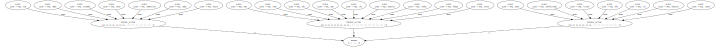

In [9]:
workflow_graph.attr(size='10')
workflow_graph

## Dealing with repetition
In the following example we have a line with some repetition. It would be a shame to look up the repeated words twice, wouldn't it? Let's build a little counter routine to check if everything is working.

In [10]:
line = "Mein Gott, mein Gott, warum hast Du mich verlassen?"
run_parallel(Translate('de', 'fr').sentence(line), n_threads=4)

'Mon <Gott>, mon <Gott>, pourquoi as Tu me quitter?'

To see how this program is being run, we monitor the job submission, retrieval and result storage in a `JobKeeper` instance.

In [11]:
from noodles.run.job_keeper import JobKeeper
from noodles.run.run_with_prov import run_parallel
from noodles import serial

J = JobKeeper(keep=True)
wf = Translate('de', 'fr').sentence(line)
run_parallel(wf,
             n_threads=4, registry=serial.base,
             jobdb_file='matthew.json', job_keeper=J)

'Mon <Gott>, mon <Gott>, pourquoi as Tu me quitter?'

Now we can see how the results were obtained by inspecting the
``JobKeeper`` object. Running the first time, you may see that
some jobs *attached* themselves to other jobs as they are identical.

Then try running above cell again. All the results should be cached
in the `matthew.json` file, and no queries are send to Glosbe, saving
us from certain doom of IP black listing.

In [12]:
from itertools import starmap
import time

def format_log_entry(tm, what, data, msg):
    return "{}: {:16} - {}".format(
        time.strftime('%Y-%m-%dT%H:%M:%SZ', time.gmtime(tm)),
        '[' + what + ']',
        data)

for k,j in J.items():
    print('\n'.join(starmap(format_log_entry, j.log)))
    print("-------------------------------------")

2017-09-19T15:01:10Z: [register]       - None
2017-09-19T15:01:10Z: [retrieved]      - mon
-------------------------------------
2017-09-19T15:01:10Z: [register]       - None
2017-09-19T15:01:10Z: [retrieved]      - pourquoi
-------------------------------------
2017-09-19T15:01:10Z: [register]       - None
2017-09-19T15:01:10Z: [retrieved]      - me
-------------------------------------
2017-09-19T15:01:10Z: [register]       - None
2017-09-19T15:01:10Z: [retrieved]      - Mon <Gott>, mon <Gott>, pourquoi as Tu me quitter?
-------------------------------------
2017-09-19T15:01:10Z: [register]       - None
2017-09-19T15:01:10Z: [retrieved]      - Tu
-------------------------------------
2017-09-19T15:01:10Z: [register]       - None
2017-09-19T15:01:10Z: [retrieved]      - Mon
-------------------------------------
2017-09-19T15:01:10Z: [register]       - None
2017-09-19T15:01:10Z: [retrieved]      - <Gott>
-------------------------------------
2017-09-19T15:01:10Z: [register]       - Non